In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2022-10-05 13:33 (eradiate v0.22.4.post102+g84ef86b.d20221005)*

We start by activating the IPython extension and importing and aliasing a few useful components. We also select the monochromatic mode.

In [2]:
%load_ext eradiate

import matplotlib.pyplot as plt
import numpy as np

import eradiate
from eradiate import unit_registry as ureg
from eradiate import scenes as ertsc
eradiate.set_mode("mono")

We set the computational mode to monochromatic, since we will be simulating scenes without atmospheres. Hence the correlated-*k* distribution method will not be useful here.

Next we set up convenience functions for plotting BRF results and visualizing camera renders.

In [3]:
def show_camera(
    exp,
    measure_id,
    robust=True,
    add_colorbar=False,
    vmin=None,
    vmax=None,
):
    """
    Display the output of a monochromatic camera measure.
    """
    _, ax = plt.subplots(1, 1)
    exp.results[measure_id]["radiance"].squeeze(drop=True).plot.imshow(
        ax=ax,
        origin="upper",
        cmap="Greys_r",
        vmin=vmin,
        vmax=vmax,
        robust=robust,
        add_colorbar=add_colorbar,
    )
    ax.set_aspect(1)  # Ensures that pixels are represented as squares
    plt.show()
    plt.close()

def show_brf(exp, measure_id):
    """
    Display the BRF output of a distant radiance measure.
    """
    _, ax = plt.subplots(1, 1)
    exp.results[measure_id]["brf"].squeeze(drop=True).plot(
        ax=ax, x="vza", linestyle=":", marker="."
    )
    plt.show()
    plt.close()

In [4]:
lambertian_surface=ertsc.surface.BasicSurface(
    shape=ertsc.shapes.RectangleShape(edges=10.0 * ureg.m),
    bsdf=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
)

In [5]:
camera_oblique = ertsc.measure.PerspectiveCameraMeasure(
    id="camera_oblique",
    origin=[15, 15, 15] * ureg.m,
    target=[0, 0, 0] * ureg.m,
    up=[0, 0, 1],
    film_resolution=(320, 240),
    spp=512,
)

In [6]:
exp = eradiate.experiments.CanopyExperiment(
    surface=lambertian_surface,
    measures=camera_oblique,
)

We run the simulation and use the convenience function defined above to visualize the result.

Mitsuba:   0%|          | 00:00, ETA=?

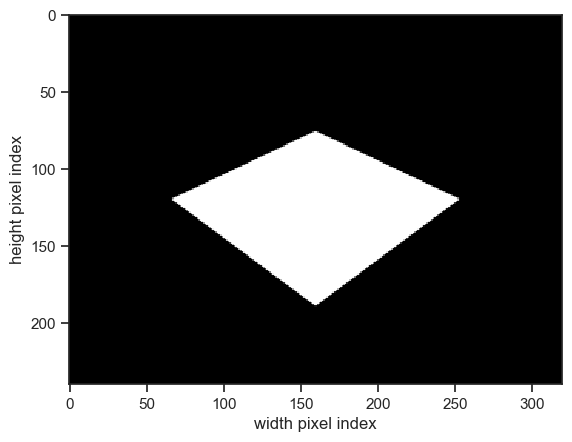

In [7]:
eradiate.run(exp)
show_camera(exp, "camera_oblique")

In [8]:
homogeneous_canopy = ertsc.biosphere.DiscreteCanopy.homogeneous(
    l_vertical=1.0 * ureg.m,
    l_horizontal=10.0 * ureg.m,
    lai=2.0,
    leaf_radius=10 * ureg.cm,
)

We create a new experiment object, which contains the canopy we just defined.

**Note:** We can now define the surface through its BSDF only, because the size of the rectangular shape is defined by the width of the canopy.

In [9]:
exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
    canopy=homogeneous_canopy,
    measures=camera_oblique,
)

We run the experiment and display the result.

Mitsuba:   0%|          | 00:00, ETA=?

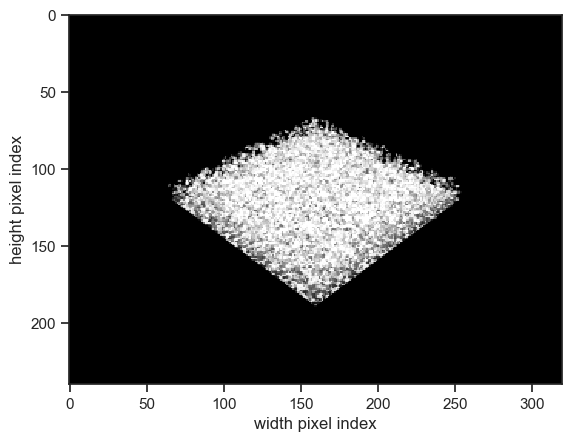

In [10]:
eradiate.run(exp)
show_camera(exp, "camera_oblique")

In [11]:
hdistant = eradiate.scenes.measure.HemisphericalDistantMeasure(spp=10000)

In [12]:
exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
    illumination=ertsc.illumination.DirectionalIllumination(
        zenith=30.0 * ureg.deg,
        azimuth=45.0 * ureg.deg,
    ),
    canopy=homogeneous_canopy,
    measures=hdistant,
)
ds = eradiate.run(exp)
ds

Mitsuba:   0%|          | 00:00, ETA=?

<xarray.Dataset>
Dimensions: (sza: 1, saa: 1, y_index: 32, x_index: 32, w: 1, srf_w: 1)
Coordinates:
 * sza (sza) float64 30.0
 * saa (saa) float64 45.0
 * y_index (y_index) int64 0 1 2 3 4 5 6 7 8 ... 23 24 25 26 27 28 29 30 31
 y (y_index) float64 0.0 0.03226 0.06452 ... 0.9355 0.9677 1.0
 * x_index (x_index) int64 0 1 2 3 4 5 6 7 8 ... 23 24 25 26 27 28 29 30 31
 x (x_index) float64 0.0 0.03226 0.06452 ... 0.9355 0.9677 1.0
 * w (w) float64 550.0
 vza (x_index, y_index) float64 86.47 86.47 86.47 ... 86.47 86.47
 vaa (x_index, y_index) float64 225.0 222.1 219.2 ... 39.19 42.1 45.0
 * srf_w (srf_w) float64 550.0
Data variables:
 radiance (sza, saa, w, y_index, x_index) float64 0.258 0.2591 ... 0.2581
 spp (sza, saa, w) int64 10000
 irradiance (sza, saa, w) float64 1.628
 srf (srf_w) float64 1.0
 brdf (sza, saa, w, y_index, x_index) float64 0.1585 0.1592 ... 0.1586
 brf (sza, saa, w, y_index, x_index) float64 0.4981 0.5001 ... 0.4982
Attributes:
 convention: CF-1.8
 source: eradiate, version 0.22.4.post102+g84ef86b.d20221005
 history: 2022-10-05 13:33:26 - data creation - CanopyExperiment.postp...
 references: 
 title: Top-of-canopy simulation results xarray.Dataset Dimensions: sza : 1 saa : 1 y_index : 32 x_index : 32 w : 1 srf_w : 1 Coordinates: (10) sza (sza) float64 30.0 standard_name : solar_zenith_angle long_name : solar zenith angle units : deg array([30.]) saa (saa) float64 45.0 standard_name : solar_azimuth_angle long_name : solar azimuth angle units : deg array([45.]) y_index (y_index) int64 0 1 2 3 4 5 6 ... 26 27 28 29 30 31 long_name : height pixel index array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]) y (y_index) float64 0.0 0.03226 0.06452 ... 0.9677 1.0 long_name : film height coordinate array([0. , 0.03225806, 0.06451613, 0.09677419, 0.12903226,
 0.16129032, 0.19354839, 0.22580645, 0.25806452, 0.29032258,
 0.32258065, 0.35483871, 0.38709677, 0.41935484, 0.4516129 ,
 0.48387097, 0.51612903, 0.5483871 , 0.58064516, 0.61290323,
 0.64516129, 0.67741935, 0.70967742, 0.74193548, 0.77419355,
 0.80645161, 0.83870968, 0.87096774, 0.90322581, 0.93548387,
 0.96774194, 1. ]) x_index (x_index) int64 0 1 2 3 4 5 6 ... 26 27 28 29 30 31 long_name : width pixel index array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]) x (x_index) float64 0.0 0.03226 0.06452 ... 0.9677 1.0 long_name : film width coordinate array([0. , 0.03225806, 0.06451613, 0.09677419, 0.12903226,
 0.16129032, 0.19354839, 0.22580645, 0.25806452, 0.29032258,
 0.32258065, 0.35483871, 0.38709677, 0.41935484, 0.4516129 ,
 0.48387097, 0.51612903, 0.5483871 , 0.58064516, 0.61290323,
 0.64516129, 0.67741935, 0.70967742, 0.74193548, 0.77419355,
 0.80645161, 0.83870968, 0.87096774, 0.90322581, 0.93548387,
 0.96774194, 1. ]) w (w) float64 550.0 standard_name : wavelength long_name : wavelength units : nm array([550.]) vza (x_index, y_index) float64 86.47 86.47 86.47 ... 86.47 86.47 standard_name : viewing_zenith_angle long_name : viewing zenith angle units : deg array([[86.47273911, 86.47273911, 86.47273911, ..., 86.47273911,
 86.47273911, 86.47273911],
 [86.47273911, 79.70531544, 79.70531544, ..., 79.70531544,
 79.70531544, 86.47273911],
 [86.47273911, 79.70531544, 73.25660146, ..., 73.25660146,
 79.70531544, 86.47273911],
 ...,
 [86.47273911, 79.70531544, 73.25660146, ..., 73.25660146,
 79.70531544, 86.47273911],
 [86.47273911, 79.70531544, 79.70531544, ..., 79.70531544,
 79.70531544, 86.47273911],
 [86.47273911, 86.47273911, 86.47273911, ..., 86.47273911,
 86.47273911, 86.47273911]]) vaa (x_index, y_index) float64 225.0 222.1 219.2 ... 42.1 45.0 standard_name : viewing_azimuth_angle long_name : viewing azimuth angle units : deg array([[225. , 222.09677419, 219.19354839, ..., 140.80645161,
 137.90322581, 135. ],
 [227.90322581, 225. , 221.89655172, ..., 138.10344828,
 135. , 132.09677419],
 [230.80645161, 228.10344

We can now visualise the data quickly using xarray's built-in plotting facilities:

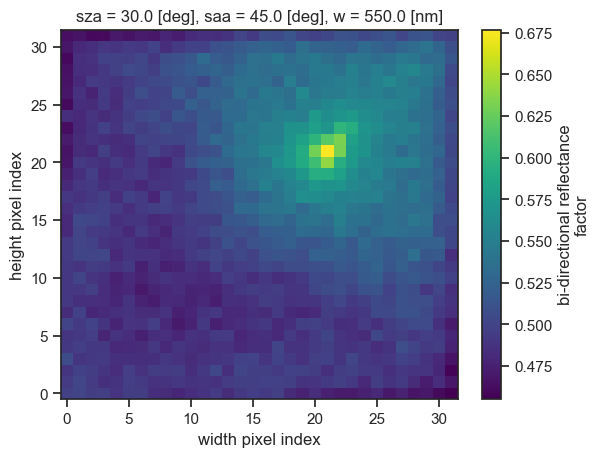

In [13]:
ds["brf"].squeeze().plot()

In [14]:
mdistant = ertsc.measure.MultiDistantMeasure.from_viewing_angles(
    id="toa_brf",
    zeniths=np.arange(-75, 76, 5),
    azimuths=45 * ureg.deg,
    spectral_cfg={"wavelengths": [550]},
    spp=10000,
)

exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
    illumination=ertsc.illumination.DirectionalIllumination(
        zenith=30.0 * ureg.deg,
        azimuth=45.0 * ureg.deg,
    ),
    canopy=homogeneous_canopy,
    measures=mdistant,
)

ds = eradiate.run(exp)
ds

Mitsuba:   0%|          | 00:00, ETA=?

<xarray.Dataset>
Dimensions: (sza: 1, saa: 1, y_index: 1, x_index: 31, w: 1, srf_w: 1)
Coordinates:
 * sza (sza) float64 30.0
 * saa (saa) float64 45.0
 * y_index (y_index) int64 0
 y (y_index) float64 0.0
 * x_index (x_index) int64 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29 30
 x (x_index) float64 0.0 0.03333 0.06667 0.1 ... 0.9333 0.9667 1.0
 * w (w) int64 550
 vza (x_index, y_index) float64 -75.0 -70.0 -65.0 ... 65.0 70.0 75.0
 vaa (x_index, y_index) float64 45.0 45.0 45.0 ... 45.0 45.0 45.0
 * srf_w (srf_w) int64 550
Data variables:
 radiance (sza, saa, w, y_index, x_index) float64 0.2523 0.2549 ... 0.2813
 spp (sza, saa, w) int64 10000
 irradiance (sza, saa, w) float64 1.628
 srf (srf_w) float64 1.0
 brdf (sza, saa, w, y_index, x_index) float64 0.155 0.1566 ... 0.1728
 brf (sza, saa, w, y_index, x_index) float64 0.487 0.492 ... 0.5429
Attributes:
 convention: CF-1.8
 source: eradiate, version 0.22.4.post102+g84ef86b.d20221005
 history: 2022-10-05 13:33:26 - data creation - CanopyExperiment.postp...
 references: 
 title: Top-of-canopy simulation results xarray.Dataset Dimensions: sza : 1 saa : 1 y_index : 1 x_index : 31 w : 1 srf_w : 1 Coordinates: (10) sza (sza) float64 30.0 standard_name : solar_zenith_angle long_name : solar zenith angle units : deg array([30.]) saa (saa) float64 45.0 standard_name : solar_azimuth_angle long_name : solar azimuth angle units : deg array([45.]) y_index (y_index) int64 0 long_name : height pixel index array([0]) y (y_index) float64 0.0 long_name : film height coordinate array([0.]) x_index (x_index) int64 0 1 2 3 4 5 6 ... 25 26 27 28 29 30 long_name : width pixel index array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]) x (x_index) float64 0.0 0.03333 0.06667 ... 0.9667 1.0 long_name : film width coordinate array([0. , 0.03333333, 0.06666667, 0.1 , 0.13333333,
 0.16666667, 0.2 , 0.23333333, 0.26666667, 0.3 ,
 0.33333333, 0.36666667, 0.4 , 0.43333333, 0.46666667,
 0.5 , 0.53333333, 0.56666667, 0.6 , 0.63333333,
 0.66666667, 0.7 , 0.73333333, 0.76666667, 0.8 ,
 0.83333333, 0.86666667, 0.9 , 0.93333333, 0.96666667,
 1. ]) w (w) int64 550 standard_name : wavelength long_name : wavelength units : nm array([550]) vza (x_index, y_index) float64 -75.0 -70.0 -65.0 ... 70.0 75.0 standard_name : viewing_zenith_angle long_name : viewing zenith angle units : deg array([[-75.],
 [-70.],
 [-65.],
 [-60.],
 [-55.],
 [-50.],
 [-45.],
 [-40.],
 [-35.],
 [-30.],
 [-25.],
 [-20.],
 [-15.],
 [-10.],
 [ -5.],
 [ 0.],
 [ 5.],
 [ 10.],
 [ 15.],
 [ 20.],
 [ 25.],
 [ 30.],
 [ 35.],
 [ 40.],
 [ 45.],
 [ 50.],
 [ 55.],
 [ 60.],
 [ 65.],
 [ 70.],
 [ 75.]]) vaa (x_index, y_index) float64 45.0 45.0 45.0 ... 45.0 45.0 45.0 standard_name : viewing_azimuth_angle long_name : viewing azimuth angle units : deg array([[45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.],
 [45.]]) srf_w (srf_w) int64 550 standard_name : wavelength long_name : wavelength units : nm array([550]) Data variables: (6) radiance (sza, saa, w, y_index, x_index) float64 0.2523 0.2549 ... 0.2834 0.2813 standard_name : radiance long_name : radiance units : W / m ** 2 / nm / sr array([[[[[0.25230533, 0.25491101, 0.25315279, 0.24893525, 0.2486759 ,
 0.24438813, 0.25072679, 0.24799858, 0.24630246, 0.25146642,
 0.26018348, 0.26529115, 0.25711104, 0.26069731, 0.27041441,
 0.27912444, 0.27618247, 0.28231436, 0.29144669, 0.29872566,
 0.31946573, 0.37136355, 0.323277 , 0.30509394, 0.29268682,
 0.29456967, 0.28664175, 0.28166696, 0.28795946, 0.28340471,
 0.28127095]]]]]) spp (sza, saa, w) int64 10000 standard_name : sample_count long_name : sample count array([[[10000]]]) irradiance (sza, saa, w) float64 1.628 standard_name : horizontal_solar_irradiance_per_unit_wavelength long_name : horizontal spectral irr

Visualisation is also greatly facilitated by xarray's plotting features. We explicitly use the `vza` (viewing zenith angle) coordinate as the *x* coordinate. We see the retro-reflective "hot spot" in the illumination direction (30°). Also note how variance typical of Monte Carlo methods appears: it can be reduced by increasing the sample count of the measure (`spp` parameter).

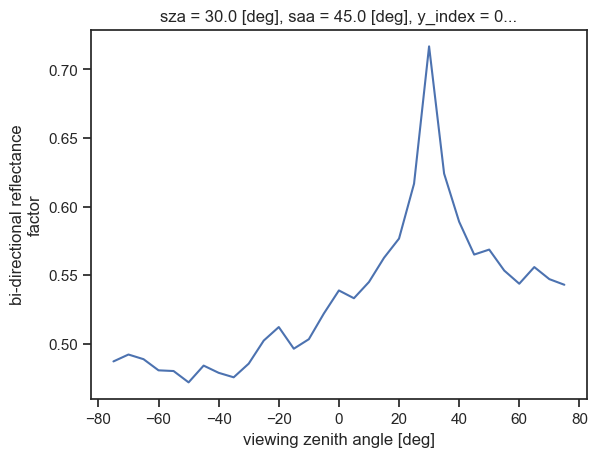

In [15]:
ds.brf.plot(x="vza");

In [16]:
exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
    canopy=homogeneous_canopy,
    padding=1,
    measures=camera_oblique,
)

Let's run this experiment and visualise the results:

Mitsuba:   0%|          | 00:00, ETA=?

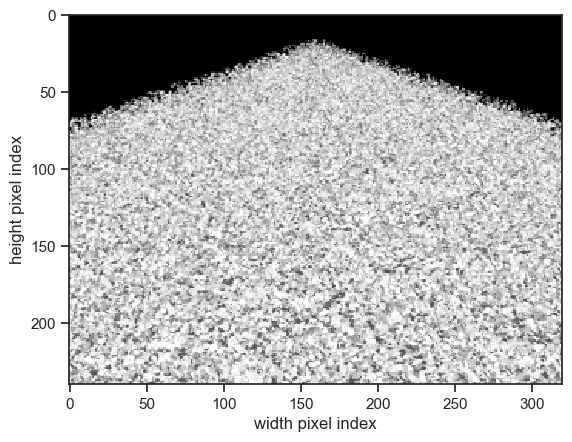

In [17]:
eradiate.run(exp)
show_camera(exp, "camera_oblique")

Our unit cell is now surrounded by a row of clones of itself: this amounts to 8 clones. Let's increase padding to 2 (we now have 8 + 16 = 24 clones):

Mitsuba:   0%|          | 00:00, ETA=?

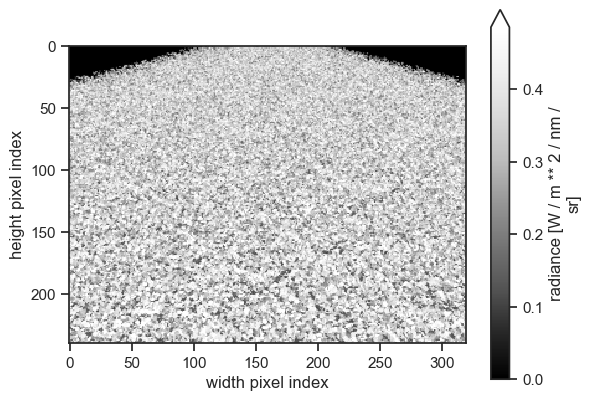

In [18]:
exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
    canopy=homogeneous_canopy,
    padding=2,
    measures=camera_oblique,
)
eradiate.run(exp)
show_camera(exp, "camera_oblique", add_colorbar=True)

We can see that the rendering time increases with padding. This is due to more pixels of the final image requiring the simulation of multiple scattering and rendering time should become approximately constant with larger padding values:

Mitsuba:   0%|          | 00:00, ETA=?

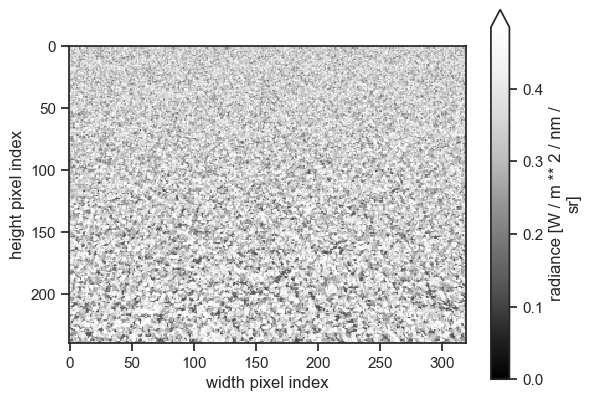

In [19]:
exp = eradiate.experiments.CanopyExperiment(
    surface=ertsc.bsdfs.LambertianBSDF(reflectance=0.5),
    canopy=homogeneous_canopy,
    padding=25,
    measures=camera_oblique,
)
eradiate.run(exp)
show_camera(exp, "camera_oblique", vmin=0.0, add_colorbar=True)